# Selling historic houses for maximum revenue with help from the King County housing data

You can find the final presentation in this folder. This notebook is where I cleaned the data, searched for correlations and visualised insights for use in the presentation.



## Scenario: advising Zachary Brooks, owner of a portfolio of historic houses

* It’s February 2016

* Zachary Brooks has a large portfolio of historical houses across King County

* He wants to sell maximum 5 properties in the next year

## Questions

* How should he sell the ones that will generate most revenue?
 
  * When is the best time to sell?
 
  * Is it worth renovating before selling?
 
  * What are the best locations to sell in?

## Approach: draw insights from past data and apply to future

The task isn't to find appropriate properties in the dataset because they have already been sold and Zachary Brooks doesn't own them.

All we can do is make generalisations about the data, and hope they apply to the next year. "Hope" being the operative word.

Start by importing all the stuff we need and changing a few settings for later on.

This includes a couple of functions defined in [my_functions.py](./my_functions.py).

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import all the functions defined in my_functions.py
from my_functions import *

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# make Seaborn a little prettier
sns.set_theme()
sns.set_color_codes()

Import the data. Note that `parse_dates` tries to parse as many date columns as it can, but it later turns out that `yr_renovated` needs some special attention.

In [2]:
# import data
df = pd.read_csv("data/King_County_House_prices_dataset.csv", parse_dates=["date", "yr_built", "yr_renovated"])
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.000,3,1.000,1180,5650,1.000,NaN,0.000,...,7,1180,0.0,1955-01-01,0.0,98178,47.511,-122.257,1340,5650
1,6414100192,2014-12-09,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,...,7,2170,400.0,1951-01-01,1991.0,98125,47.721,-122.319,1690,7639
2,5631500400,2015-02-25,180000.000,2,1.000,770,10000,1.000,0.000,0.000,...,6,770,0.0,1933-01-01,NaN,98028,47.738,-122.233,2720,8062
3,2487200875,2014-12-09,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,...,7,1050,910.0,1965-01-01,0.0,98136,47.521,-122.393,1360,5000
4,1954400510,2015-02-18,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,...,8,1680,0.0,1987-01-01,0.0,98074,47.617,-122.045,1800,7503


Look at all those lovely columns. It later turns out we don't need anywhere near all of them, so we can drop quite a lot.


In [3]:
df = df.iloc[:, [0, 1, 2, 10, 14, 15, 16, 17, 18]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            21597 non-null  int64         
 1   date          21597 non-null  datetime64[ns]
 2   price         21597 non-null  float64       
 3   condition     21597 non-null  int64         
 4   yr_built      21597 non-null  datetime64[ns]
 5   yr_renovated  17755 non-null  object        
 6   zipcode       21597 non-null  int64         
 7   lat           21597 non-null  float64       
 8   long          21597 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(3), object(1)
memory usage: 1.5+ MB


In [4]:
# Just do describe on price and condition as it doesn't make sense for the others.
df.iloc[:, 2:4].describe()

,price,condition
count,21597.000,21597.000
mean,540296.574,3.410
std,367368.140,0.651
min,78000.000,1.000
25%,322000.000,3.000
50%,450000.000,3.000
75%,645000.000,4.000
max,7700000.000,5.000


|    | Column name   | Description   |
|---:|:--------------|:--------------|
|  1 | date          | Date of the sale             |
|  2 | price         | Price of sale |
|  3 | condition     | Condition on a scale of 1 to 5 |
| 4 | yr_built      | Year property was built |
| 5 | yr_renovated  | Year property was last renovated |
| 6 | zipcode       | Zip code |
| 7 | lat           | Latitude |
| 8 | long          | Longitude |

## Clean `yr_renovated` column

`yr_renovated` didn't get imported as a datetime object, so we need to clean it. The problem is that it contains lots of 0.0 values that can't be detected as NaN.

In [5]:
df["yr_renovated"] = pd.to_datetime(
    df["yr_renovated"].replace("0.0", np.NaN), format="%Y.0"
    )

df["yr_renovated"].dtype

dtype('<M8[ns]')

### The `price` data is heavily right-skewed

Okay, let's admit it: price is what we're interested in most. Let's see how the data is distributed with a nice box plot.

<AxesSubplot:>

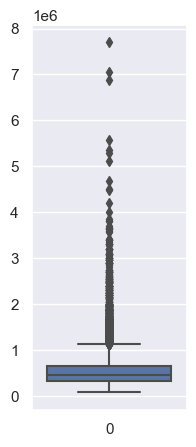

In [6]:
fig, ax = plt.subplots(figsize=(2, 5))
sns.boxplot(ax=ax, data=df["price"])


We can see there are many outliers, so the data is heavily right-skewed.

The mean is $540k but the median is $450k.

## Where to sell?

### Highest-value zip codes

We start by finding the 5 zip codes with the highest mean price.

`get_zip_averages` is defined in `my_functions.py`. It gets the mean price for every zipcode by default, but can also get median and mode.

In [7]:
zips = get_zip_averages(df, mean_only=False)
zips

/Users/johnheaven/neuefische/ds-eda-project/.venv/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:1476: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  f = lambda x: func(x, *args, **kwargs)


,mean_price,median_price,mode_price,count,latitude,longitude,name
zipcode,,,,,,,
98001,281000,260000,"([250000.0], [9])",361,47.310,-122.265,Auburn
98002,234000,235000,"([250000.0], [8])",199,47.305,-122.207,Auburn
98003,294000,267000,"([225000.0], [7])",280,47.320,-122.312,Federal Way
98004,1357000,1150000,"([650000.0], [7])",317,47.615,-122.207,Bellevue
98005,810000,765000,"([530000.0], [4])",168,47.615,-122.166,Bellevue
...,...,...,...,...,...,...,...
98177,676000,554000,"([380000.0], [5])",255,47.747,-122.369,Seattle
98178,311000,278000,"([200000.0], [5])",262,47.492,-122.236,Seattle
98188,289000,264000,"([240000.0], [5])",136,47.448,-122.273,Seattle


Map the zipcodes using Plotly.

The `map_zips` function is used throughout this part of the notebook tot keep the plots consistent and make it easier to make small changes in one place. It optionally writes the plots to HTML and JPEG for use e.g. in presentations.

In [8]:
def map_zips(zips, title="Zip Codes in King's County", width=800, height=600, color="mean_price", size="count", save_html=False, save_jpg=False):
    """ Maps zip codes with Seaborn, optionally saves output to HTML or JPEG files too

    Args:
        zips (_type_): _description_
        title (str, optional): The title. Defaults to "Zip Codes in King's County".
        sizecount (bool, optional): Whether size is the count (i.e. number of data). Defaults to False.
        save_html (bool, optional): Whether to save to HTML. Defaults to True.
        save_jpg (bool, optional):
    """
    import plotly.express as px
    zips = zips.copy()
    zips["_prefix"] = " ("
    zips["_suffix"] = ")"
    zips["hover"] = zips.index.astype(str) + zips["_prefix"] + zips["name"] + zips["_suffix"]
    fig = px.scatter_mapbox(
        zips,
        mapbox_style="stamen-toner",
        lat="latitude",
        lon="longitude",
        color=color,
        title=title,
        hover_name="hover",
        width=width,
        height=height,
        size=size,
        zoom=8.5,
        #color_continuous_scale=["#f3ff6e", "#083d04"]
        )

    fig.show()
    if save_html or save_jpg:
        file_name = title.replace(" ", "_")
        file_name = ''.join(e for e in file_name if (e.isalnum() or e == "_")).lower()
    if save_html:
        fig.write_html(f"html/{file_name}.html")
    if save_jpg:
        pass
        fig.write_image(f"images/{file_name}.jpg", width=width, height=height)
map_zips(zips, title="Zip Codes in King's Country: Average Price", save_html=True)

From the map, we can see the point at which things get expensive is around 850k. This is well above the 75th %ile for the mean price on zip codes.

In [9]:
print(f"The 75th percentile is: {int(round(zips['mean_price'].quantile(0.75), -3))}")

The 75th percentile is: 646000


### Let's get the top 5 zipcodes


By mean

In [10]:
top_5_zips = zips.sort_values("mean_price", ascending=False).iloc[0:5]
top_5_zips.drop(columns=["latitude", "longitude", "median_price", "mode_price"])

,mean_price,count,name
zipcode,,,
98039,2161000,50,Medina
98004,1357000,317,Bellevue
98040,1195000,282,Mercer Island
98112,1096000,269,Seattle
98102,900000,104,Seattle


By median

In [11]:
top_5_zips_median = top_5_zips = zips.sort_values("median_price", ascending=False).iloc[0:5]
top_5_zips_median.drop(columns=["latitude", "longitude", "mean_price", "mode_price"])


,median_price,count,name
zipcode,,,
98039,1895000,50,Medina
98004,1150000,317,Bellevue
98040,994000,282,Mercer Island
98112,915000,269,Seattle
98005,765000,168,Bellevue


They're the same...

In [12]:
# The zipcode is the index...
top_5_zips.index.equals(top_5_zips_median.index)

True

In [13]:
map_zips(top_5_zips, title="Top 5 most expensive zip codes")

### Get figures (average prices) for historical buildings (built before 1945) in all zipcodes

In [14]:
# save this for later use
historic_year = pd.to_datetime("1945-12-31", yearfirst=True)

# masks come in handy later - you can reuse them to filter, and even combine them with &, | etc.
# so you don't have to write the same queries over and over again.
# I think you'd have to be careful using them on filtered DataFrames though, because they afaik
# filter purely by order (not by index/row number) - so if the number of rows change, it will be all off.
# The index should be retained, though, so it might be possible to use that if necessary.

mask_historic = df["yr_built"] < historic_year

# Get stats historic buildings in all zips in the dataset
historical_zips = get_zip_averages(df[mask_historic], mean_only=False)
map_zips(historical_zips, title="Zip Codes by Average Price, Historical Only")

/Users/johnheaven/neuefische/ds-eda-project/.venv/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:1476: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



Here we can clearly see the range of prices in various zip codes.
* The cheapest neighbourhoods start at $0.2M
* The priciest range up to almost $2M

### Get top 5 zips for historical properties

By mean...

In [15]:
top_historical_zips = historical_zips.drop(columns=["latitude", "longitude", "median_price", "mode_price"]).sort_values("mean_price", ascending=False).iloc[0:5]
top_historical_zips

,mean_price,count,name
zipcode,,,
98004,1918000,12,Bellevue
98008,1700000,1,Bellevue
98040,1493000,9,Mercer Island
98039,1440000,4,Medina
98112,1124000,168,Seattle


And by median...

In [16]:
top_historical_zips_median = historical_zips.sort_values("median_price", ascending=False).iloc[0:5]
top_historical_zips_median.drop(columns=["latitude", "longitude", "mean_price", "mode_price"])

,median_price,count,name
zipcode,,,
98008,1700000,1,Bellevue
98039,1475000,4,Medina
98004,1330000,12,Bellevue
98040,1250000,9,Mercer Island
98112,918000,168,Seattle


In [17]:
top_historical_zips.index.equals(top_historical_zips_median.index)

False

In [18]:
len(set(top_historical_zips.index).symmetric_difference(set(top_historical_zips_median.index)))

0

**The zipcodes are the same, but in a different order**. So let's choose the median when we plot them on the map.

In [19]:
map_zips(top_historical_zips_median, title="Top 5 historical zip codes by median price", color="median_price")

Are these different from the overall most expensive zip codes? They have four in common - only two are in one but not the other.

In [20]:
set(top_historical_zips.index).symmetric_difference(top_5_zips.index)

{98005, 98008}

### Only those zip codes with a minimum number of properties

You might worry that some zipcodes have very thin data. So we want to show only zip codes with a minimum number of properties. We can't be too choosy as many zipcodes have a low number of historic properties. **Let's set the threshold at 10**.

In [21]:
top_historical_zips_min_count = historical_zips[historical_zips["count"] >= 10].sort_values("median_price", ascending=False).iloc[0:5]
map_zips(top_historical_zips_min_count, "Top 5 historical zip codes, n > 10", size="count", color="median_price")

Does this give us different results than without the n > 10 criterion?

In [22]:
set(top_historical_zips_min_count.index).intersection(set(top_historical_zips.index))

{98004, 98112}

Again, there are two that are in one but not the other.

## Conclusion: Where to sell

It's clear from the data that there are 5 zipcodes with a minimum number of sales to assess whether the data is accurate. Depending on the properties Mr Brooks possesses, the following zip codes would be advantageous:

In [23]:
top_historical_zips_median["name"].to_frame()

,name
zipcode,
98008,Bellevue
98039,Medina
98004,Bellevue
98040,Mercer Island
98112,Seattle


## Should I sell now, or wait until autumn?

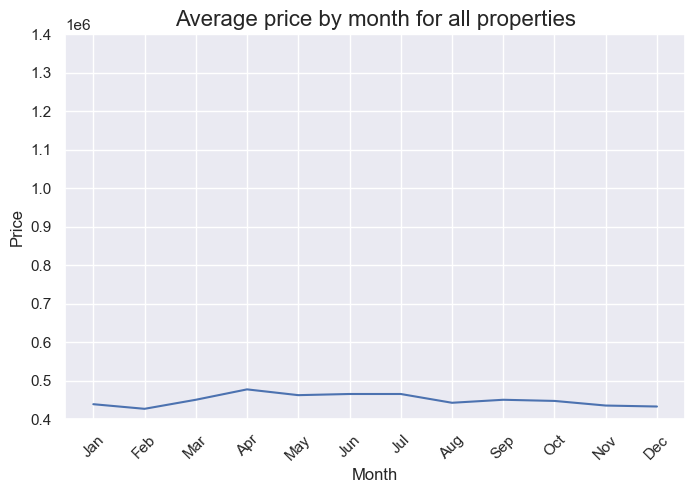

In [24]:
def plot_monthly_prices(df, title=None, ytick_lim=1.4e6, cut_y=4e5):
    fig, ax = plt.subplots()
    df = df.copy()
    df["month"] = df["date"].dt.month
    df_month_prices = df[["month", "price"]].groupby("month").median()
    p = sns.lineplot(axes=ax, data=df_month_prices, x="month", y="price")
    plt.xticks(rotation=45)

    # calculate upper limit for y axis (ytick_lim) with padding to next 100,000 unless one is passed as argument
    if ytick_lim is None:
        pricemax = df_month_prices["price"].max()
        ytick_lim = pricemax - (pricemax // 1e5)

    ax.set_yticks(ticks=np.arange(cut_y, ytick_lim + 1e5, 1e5))
    ax.set_xticks(ticks=df_month_prices.index, labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Month")
    ax.set_ylabel("Price")

plot_monthly_prices(df, title="Average price by month for all properties")

The above chart **with y-axis cut at 400,000** shows that there are fluctuations in the market. While the overall percentage is relatively small if plot with a full y-axis, there is nevertheless quite a lot of money at stake if the trend holds in coming years. We've set the upper limit to 1.2m for comparability with the following chart.

Also note that the months January to May are from 2015, while May to December are from 2014 (and May overlaps for a few days).

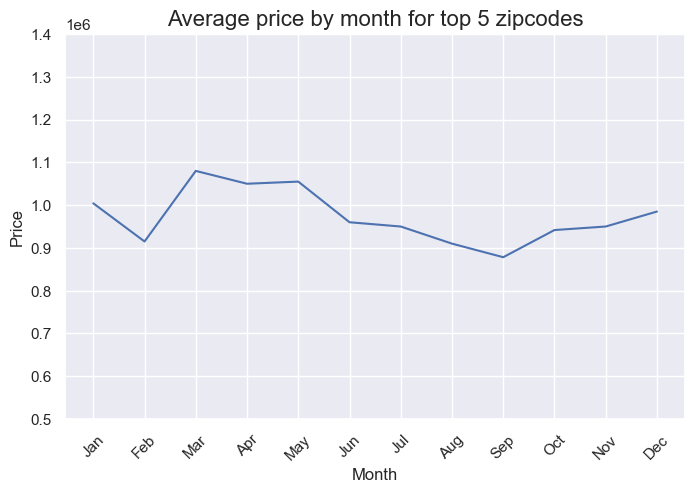

In [25]:
# For top-five zip codes
mask_top_5_zips = df["zipcode"].isin(top_5_zips.index.to_list())
plot_monthly_prices(df[mask_top_5_zips], "Average price by month for top 5 zipcodes", ytick_lim=1.4e6, cut_y=5e5)

For the top zip-codes, price-wise it makes little difference whether we sell now or in autumn. There's a larger window of opportunity now though.

If we do renovate, there's a chance to sell in autumn, but if things take longer, the spring window is waiting just after New Year.

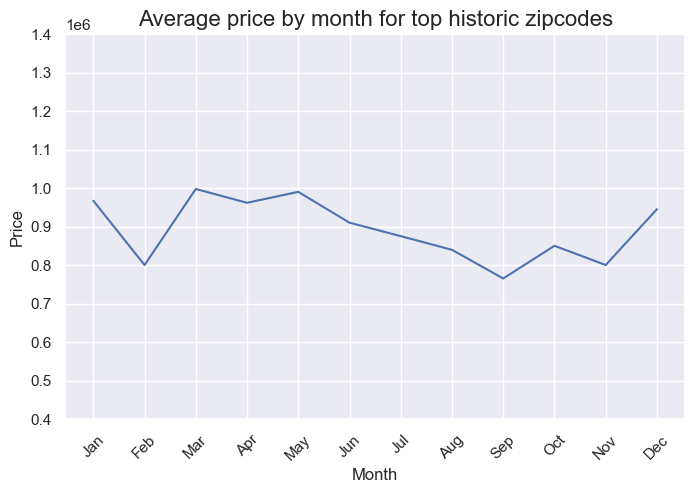

In [26]:
# For top five historic zip codes
mask_top_historical_zips = df["zipcode"].isin(top_historical_zips.index.to_list())
plot_monthly_prices(df[mask_top_historical_zips], title="Average price by month for top historic zipcodes")

For the top historic zipcodes, the picture is slightly different. Autumn is about the worst time to sell!

Is this because of low number of properties in the data?

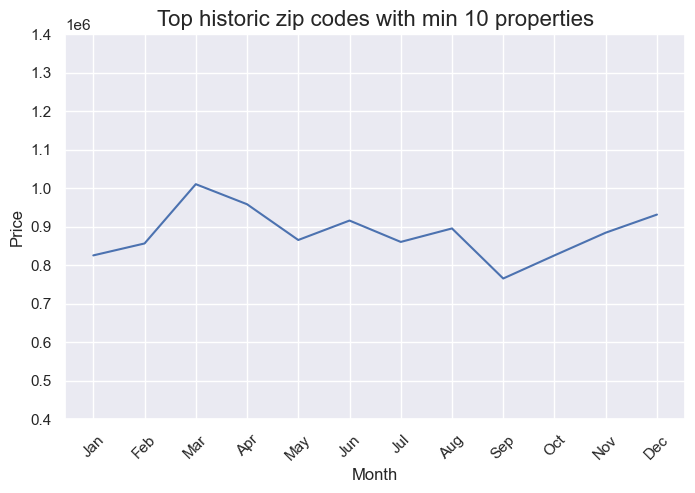

In [27]:
mask_top_historical_zips_min_count = df["zipcode"].isin(top_historical_zips_min_count.index.to_list())
plot_monthly_prices(df[mask_top_historical_zips_min_count], "Top historic zip codes with min 10 properties")

Conclusion: historic properties sold for lowest prices in autumn, with about $200k difference between the lowest and highest points. This means it would be wise to put the properties on the market now, in order to have best chances of maximising revenue.

This assumes that putting five properties on the market won't cannibalise one another by self-competing.

## Should I renovate?

Only a small percentage of the dataset has information on renovation date. So we should be suspicious.

In [28]:
def pc_ren(df, return_value=False):
    if not return_value:
        percent_renovated = df["yr_renovated"].count() / df.index.size * 100
        print(f"{round(percent_renovated, 2)}% of buildings have been renovated.")
    else:
        return percent_renovated

pc_ren(df)

3.44% of buildings have been renovated.


What about historic buildings?

In [29]:
pc_ren(df[mask_historic])

10.23% of buildings have been renovated.


This is surprising... so we should take it with a pinch of salt.

In [30]:
# add a column "really_renovated" – this is either the year renovated, or the year of build if NaN

not_renovated_mask = df["yr_renovated"].notna()
bad_condition_mask = df["condition"] <= 3

df["really_renovated"] = df["yr_renovated"].fillna(df["yr_built"])
df

,id,date,price,condition,yr_built,yr_renovated,zipcode,lat,long,really_renovated
0,7129300520,2014-10-13,221900.000,3,1955-01-01,NaT,98178,47.511,-122.257,1955-01-01
1,6414100192,2014-12-09,538000.000,3,1951-01-01,1991-01-01,98125,47.721,-122.319,1991-01-01
2,5631500400,2015-02-25,180000.000,3,1933-01-01,NaT,98028,47.738,-122.233,1933-01-01
3,2487200875,2014-12-09,604000.000,5,1965-01-01,NaT,98136,47.521,-122.393,1965-01-01
4,1954400510,2015-02-18,510000.000,3,1987-01-01,NaT,98074,47.617,-122.045,1987-01-01
...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.000,3,2009-01-01,NaT,98103,47.699,-122.346,2009-01-01
21593,6600060120,2015-02-23,400000.000,3,2014-01-01,NaT,98146,47.511,-122.362,2014-01-01
21594,1523300141,2014-06-23,402101.000,3,2009-01-01,NaT,98144,47.594,-122.299,2009-01-01
21595,291310100,2015-01-16,400000.000,3,2004-01-01,NaT,98027,47.535,-122.069,2004-01-01


In [31]:
condition_renovation = df[["condition", "yr_renovated"]].groupby("yr_renovated").mean()
condition_renovation

,condition
yr_renovated,
1934-01-01,5.000
1940-01-01,3.500
1944-01-01,4.000
1945-01-01,3.333
1946-01-01,3.000
...,...
2011-01-01,3.111
2012-01-01,3.000
2013-01-01,3.065


Text(0.5, 1.0, 'Year renovated against condition')

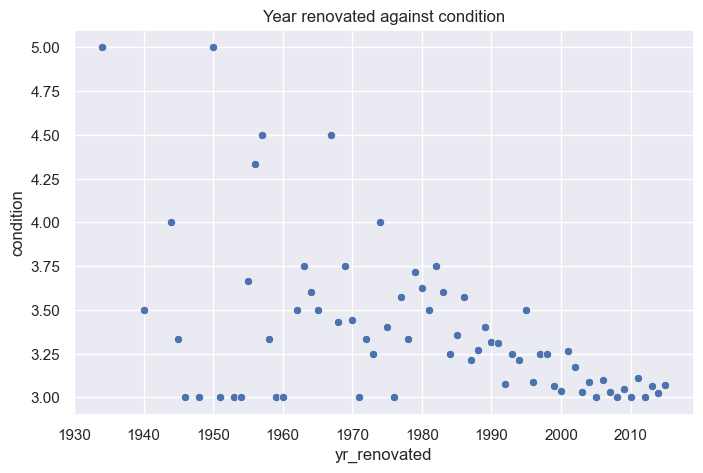

In [32]:
p = sns.scatterplot(condition_renovation, x="yr_renovated", y="condition")
p.set_title("Year renovated against condition")

<AxesSubplot:xlabel='really_renovated'>

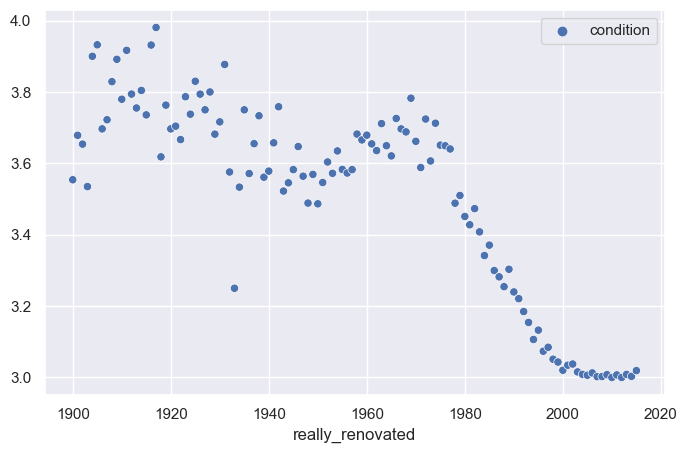

In [33]:
# find average condition by really_renovated year
condition_x_ren_year = df[["really_renovated", "condition"]].groupby("really_renovated").mean()
sns.scatterplot(data=condition_x_ren_year)

Does yr_renovated really add anything? Let's do the same, but for just the build year.

Text(0.5, 1.0, 'Year built against condition')

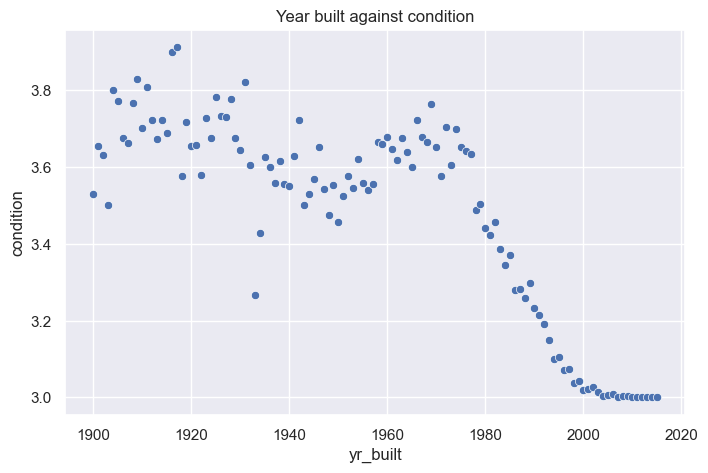

In [34]:
condition_x_build_year = df[["yr_built", "condition"]].groupby("yr_built").mean()
p = sns.scatterplot(data=condition_x_build_year, x="yr_built", y="condition")
p.set_title("Year built against condition")

All the scattergraphs seem to show that the year or renovation/build is actually negatively correlated to condition. We can see that older objects generally are in better condition.

**We can't conclude very much from the data because we would expect condition to correlate with renovation... but the opposite is the case. We can assume that condition is valid, and yr_renovated is not.**

### Is there any correlation between condition and price?

In [35]:
# Separate into price bands, group by average condition, and plot a scatter graph
def mean_condition_x_price_band(df, bins=10, return_pb=False):
    df = df[["price", "condition"]].copy()
    df["price_bands"] = pd.cut(df["price"], bins=bins, labels=range(1, bins+1))
    df_pb_x_c = groupby_avg_and_len(df, use_cols=["price_bands", "condition"], groupby_col="price_bands")
    if return_pb:
        price_bands = groupby_avg_and_len(df, use_cols=["price_bands", "price"], groupby_col="price_bands")
        return (df_pb_x_c, price_bands)
    else:
        return df
condition_x_priceband, price_bands = mean_condition_x_price_band(df, return_pb=True)
condition_x_priceband

,mean_condition,count
price_bands,,
1,3.403,19053
2,3.454,2118
3,3.503,298
4,3.522,90
5,3.500,26
6,3.000,4
7,3.250,4
8,3.000,1
9,3.000,1


<AxesSubplot:xlabel='price_bands', ylabel='mean_condition'>

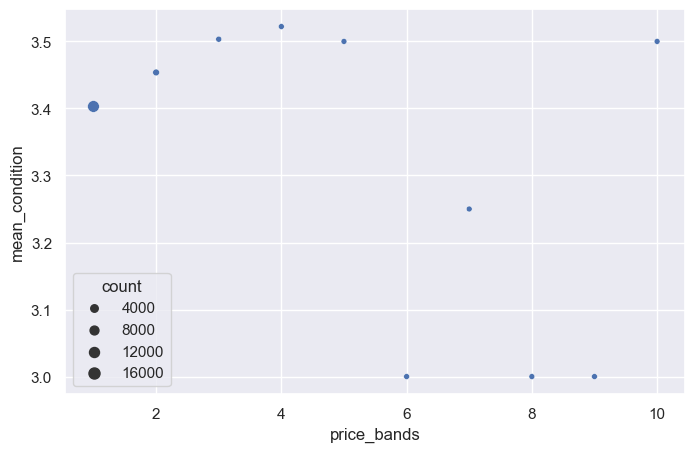

In [36]:
sns.scatterplot(data=condition_x_priceband, x=condition_x_priceband.index, y="mean_condition", size="count")

It looks like there is a correlation between price and condition. Many of the price bands don't have much data. Let's make a cut-off of at least 50 properties.

Text(0.5, 1.0, 'Price bands and their average condition rating, n >= 50')

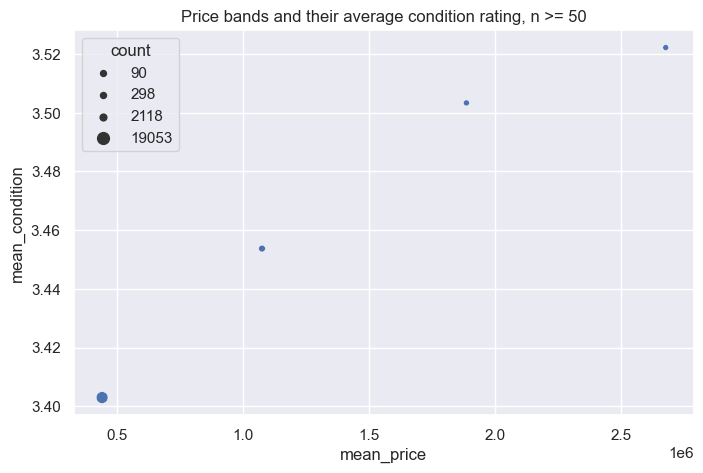

In [37]:
data = condition_x_priceband[condition_x_priceband["count"]>=50].join(price_bands, how="left", rsuffix="_r")
p = sns.scatterplot(data=data, x="mean_price", y="mean_condition", size="count")
p.set_title("Price bands and their average condition rating, n >= 50")

### Correlation between condition and price for historic properties?

<AxesSubplot:xlabel='mean_price', ylabel='mean_condition'>

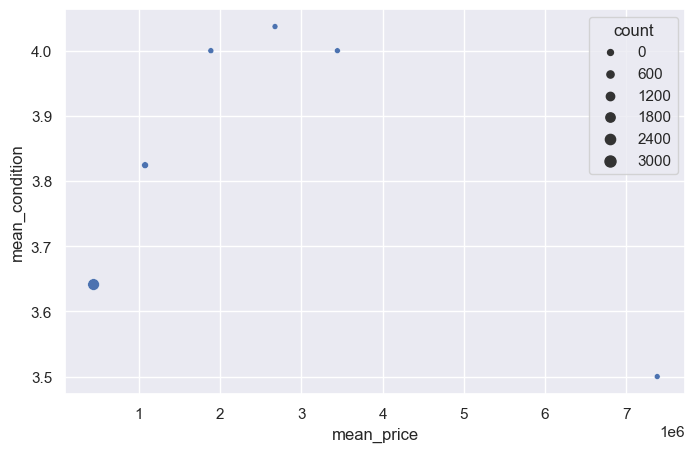

In [38]:
condition_x_priceband_hist, price_bands_hist = mean_condition_x_price_band(df[mask_historic], return_pb=True)
data = condition_x_priceband_hist.join(other=price_bands, how="left", rsuffix="_r")
sns.scatterplot(data=data, x="mean_price", y="mean_condition", size="count")

It seems to be the same story - let's see how much data we have for each price band

In [39]:
price_bands_hist

,mean_price,count
price_bands,,
1,455437.566,3581
2,1066668.423,444
3,1925263.158,57
4,2624814.815,27
5,3391666.667,6
6,NaN,0
7,NaN,0
8,NaN,0
9,NaN,0


We're going to have to be less choosy if we want to see data for the highest price bands and go right down to 5!

Text(0.5, 1.0, 'Price band against mean condition, historic buildings, n >= 5')

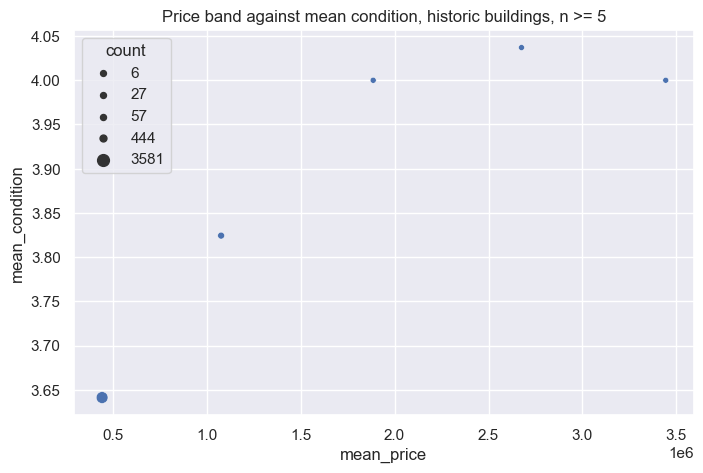

In [40]:
data = condition_x_priceband_hist[condition_x_priceband_hist["count"] >=5].join(other=price_bands, how="left", rsuffix="_r")
p = sns.scatterplot(data=data, x="mean_price", y="mean_condition", size="count")
p.set_title("Price band against mean condition, historic buildings, n >= 5")

### There were no properties that renovated then resold in the timeframe :(

Only 14 renovated then sold within the timeframe.

In [41]:
# Get "duplicates" - i.e. sold at least twice
# find relisted (i.e. duplicate) properties
relisted_mask = df.index.duplicated(keep=False)

# Get those that were renovated in dataset timeframe
renovated_in_timeframe_mask = df["yr_renovated"] >= df["date"].min()

# Get those that weren't renovated in timeframe
not_renovated_in_timeframe_mask = ~renovated_in_timeframe_mask

# Only 14 renovated and sold within the timeframe
df[renovated_in_timeframe_mask]

# Exclude those that were renovated twice - only include those with an ID in both
#ids = pd.merge(left=df[renovated_in_timeframe_mask]["id"], right=df[not_renovated_in_timeframe_mask]["id"], how="inner", on="id")

# Groupby renovation status and average price
# Calculate difference
# Can do this in various segments

,id,date,price,condition,yr_built,yr_renovated,zipcode,lat,long,really_renovated
2293,8712100320,2014-07-28,585000.000,3,1922-01-01,2015-01-01,98112,47.639,-122.300,2015-01-01
3153,6821100195,2015-03-31,830000.000,3,1968-01-01,2015-01-01,98199,47.656,-122.401,2015-01-01
4236,6071800100,2015-03-27,815000.000,3,1962-01-01,2015-01-01,98006,47.546,-122.175,2015-01-01
5678,2202500255,2015-03-05,335000.000,4,1954-01-01,2015-01-01,98006,47.573,-122.135,2015-01-01
7090,9141100005,2014-10-28,285000.000,3,1940-01-01,2015-01-01,98133,47.741,-122.355,2015-01-01
7410,8665900328,2015-01-23,459000.000,3,1954-01-01,2015-01-01,98155,47.768,-122.304,2015-01-01
8683,8835401250,2015-05-06,1490000.000,3,1964-01-01,2015-01-01,98118,47.546,-122.265,2015-01-01
11587,7284900030,2014-05-22,850000.000,3,1923-01-01,2015-01-01,98177,47.768,-122.388,2015-01-01
11621,461004730,2015-04-06,717000.000,3,1959-01-01,2015-01-01,98117,47.681,-122.369,2015-01-01
14845,3585900665,2014-06-06,805000.000,3,1956-01-01,2015-01-01,98177,47.761,-122.378,2015-01-01


In [42]:
# They went for $0.7m on average - relatively low
np.around(df[renovated_in_timeframe_mask]["price"].mean(), -3) / 1e6

0.697

### Whether to renovate: Conclusion
We can conclude that:
* condition appears to have an impact on price, when you exclude the bands with very little data
* however, the information on condition is relatively limited - it all falls within quite a small range
* the data is thin above band 5, roughly the $2.5 million price tag
* the data is very thin for historical properties. HOWEVER -> a small increase in condition seems to correlate with a large increase in price.

* Now seems to be a good time to sell, and given the uncertainty in the data, and the risk that is associated with renovating (which could take longer than expected and cost more), it makes sense to pick properties for sale that are in a reasonably good condition already (as far above 3 as possible) but not to renovate them.

## Overall conclusion

* The best districts to sell for historical buildings are: ...
* Sell now!
* Don't renovate!